# CIFAR-10 Example with CNN Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ExponentialLR

from torchvision import transforms, datasets

import ssl # maybe necessary to avoid ssl certificate error
ssl._create_default_https_context = ssl._create_unverified_context

import matplotlib.pyplot as plt
import numpy as np
import time

## Load the internal data from `torchvision.datasets`

In [2]:
train_data = datasets.CIFAR10(root = '.data', train = True, download=True, transform = transforms.ToTensor())
test_data  = datasets.CIFAR10(root = '.data', train = False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = train_data.class_to_idx
print(class_names)
class_idx_to_names = dict([(j,i) for i,j in class_names.items()])
print(class_idx_to_names)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


Subset to 5000 training and 1000 testing

---



In [4]:
np.random.seed(500)
train_idx = np.random.choice(len(train_data), round(len(train_data)*0.1), replace=False)
test_idx = np.random.choice(len(test_data), round(len(test_data)*0.1), replace=False)

train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

print(train_data)
print(len(train_data))

print(test_data)
print(len(test_data))

5000
1000


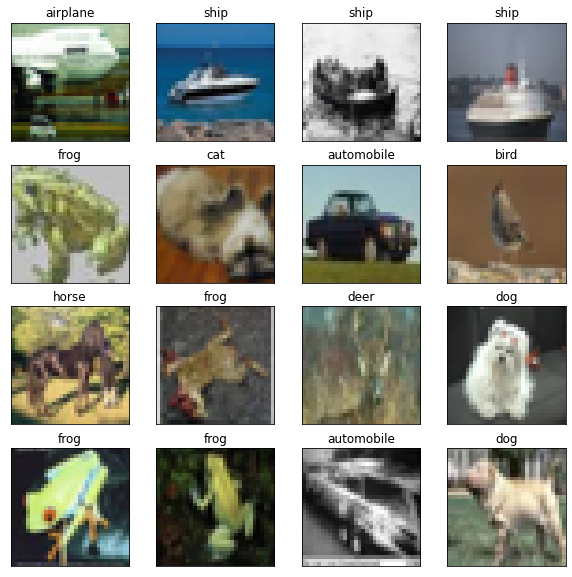

In [5]:
def img_plotter(img_list, lab_list):
    ncols = 4
    nrows = int(np.ceil(len(img_list)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5))
    for i in range(len(img_list)):
        image = img_list[i]
        label = lab_list[i]
        ax = axes.flat[i]
        if len(image.shape) == 3:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        else:
            ax.imshow(image.numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])

# View the first few images
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Pre-process the data

Since the images already have standardized sizes, this step will only do normalization and random changes.

In [6]:
# Find the mean and standard deviation of the training data
image_mean = []
image_szs  = []

for image, label in DataLoader(train_data, batch_size=1, shuffle=False):
    image_mean.append(image.mean(dim=[0,2,3])) # the first dimension is batch size
    image_szs .append(tuple(image.size()[2:]))

means = torch.stack(image_mean).mean(dim = 0)
stds  = torch.stack(image_mean).std (dim = 0)

print(f'Mean values of each channel: {means}')
print(f'Mean values of each channel: {stds }')

Mean values of each channel: tensor([0.4916, 0.4831, 0.4491])
Mean values of each channel: tensor([0.1267, 0.1240, 0.1513])


In [7]:
# Re-load the data with transformations
# - transforms.RandomRotation: randomly rotate within (min,max) or +/-degrees range
# - transforms.RandomHorizontalFlip: randomly horizontal flip with given probability
# - transforms.RandomCrop: crop the image to given size, and optionally pad the edge of the image
train_transforms = transforms.Compose([
                          #  transforms.RandomRotation(5),
                          #  transforms.RandomHorizontalFlip(0.5),
                          #  transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])


torch.manual_seed(999)

train_data = datasets.CIFAR10('./data', train=True, download=True,
                              transform=test_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True,
                             transform=test_transforms)

# subset again
train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

batch_size = 10
train_iterator = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iterator = DataLoader(test_data, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_iterator
for i, (img_list, lab_list) in enumerate(train_iterator):
  break

print(img_list.shape, img_list.dtype)
print(lab_list.shape, img_list.dtype)

torch.Size([10, 3, 32, 32]) torch.float32
torch.Size([10]) torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

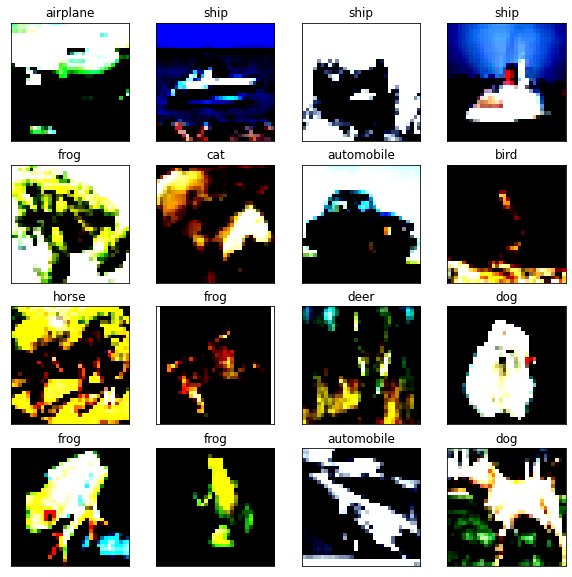

In [9]:
# RView the first few images after transformation
# Note the warnings occur because the normalization causes the values of image 
#   pixels to be out of the range of [0,1]. matplotlib expects the values of 
#   every pixel to be between [0,1], and clips out of range values. 
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Define the Model

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(   # 3 x 32 x 32
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Conv2d(48, 24, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

            # nn.Conv2d(3, 16, 3, 2, 1),  # 16 x 16 x 16
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2), # 16 x 8 x 8
            # nn.Conv2d(16, 8, 3, 2, 1), # 8 x 4 x 4
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2), # 8 x 2 x 2
        )

        # self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        self.decoder = nn.Sequential( # 8 x 2 x 2
            nn.ConvTranspose2d(24, 48, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),

            # nn.ConvTranspose2d(8, 8, 3, 2, 1, output_padding=1), # 8 x 4 x 4 
            # nn.ReLU(),
            # nn.ConvTranspose2d(8, 16, 3, 2, 1, output_padding=1), # 16 x 8 x 8 
            # nn.ReLU(),
            # nn.ConvTranspose2d(16, 16, 3, 2, 1, output_padding=1), # 16 x 16 x 16
            # nn.ReLU(),
            # nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # 3 x 32 x 32
            # nn.Tanh()

            # nn.ConvTranspose2d(8, 16, 3, 2), # 16 x 5 x 5
            # nn.ReLU(True), # inplace = True
            # nn.ConvTranspose2d(16, 8, 5, 2, 1), # 8 x 11 x 11
            # nn.ReLU(True),
            # nn.ConvTranspose2d(8, 3, 3, 3, 1, 1), # 3 x 32 x 32
            # nn.Tanh()
        )

    def forward(self, x):
        # x.shape
        x= self.encoder(x)
        # x = self.unpool(x, indices)
        x = self.decoder(x)
        # x.shape
        return x

## Instantiate the model, define loss and optimization functions

In [11]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()
num_epochs = 200

## Train the Model

In [12]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

# model.apply(initialize_parameters)

In [13]:
def train_model(num_epochs, model, train_iterator, optimizer, criterion, device):
    start_time = time.time()

    train_epochs = num_epochs
    train_losses = []

    model.to(device) # attach model to device
    criterion.to(device) # attach loss function to device

    for i in range(train_epochs):
        for j, (img_list, _) in enumerate(train_iterator):

            img_list = img_list.to(device) # attach training data to device

            img_pred = model(img_list)
            loss = criterion(img_pred, img_list)

            # if j%200 == 0:
            #     print(f'epoch: {i:2}  batch: {j:4} [{batch_size*j:6}/5000]  loss: {loss.item():10.8f}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'epoch: {i + 1} loss: {loss.item():.4f}')
        train_losses.append(loss)

    # scheduler.step()

    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    return train_losses

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses = train_model(num_epochs, model, train_iterator, optimizer, criterion, device)

epoch: 1 loss: 2.5054
epoch: 2 loss: 2.3470
epoch: 3 loss: 2.7264
epoch: 4 loss: 2.6194
epoch: 5 loss: 2.1473
epoch: 6 loss: 3.2778
epoch: 7 loss: 3.0169
epoch: 8 loss: 2.4098
epoch: 9 loss: 2.3621
epoch: 10 loss: 2.8673
epoch: 11 loss: 1.9546
epoch: 12 loss: 2.2330
epoch: 13 loss: 2.8178
epoch: 14 loss: 1.9234
epoch: 15 loss: 2.1248
epoch: 16 loss: 2.6072
epoch: 17 loss: 1.7169
epoch: 18 loss: 2.1463
epoch: 19 loss: 2.6768
epoch: 20 loss: 2.5363
epoch: 21 loss: 1.6016
epoch: 22 loss: 1.9290
epoch: 23 loss: 2.2459
epoch: 24 loss: 2.0687
epoch: 25 loss: 3.2576
epoch: 26 loss: 2.6439
epoch: 27 loss: 2.1201
epoch: 28 loss: 2.4297
epoch: 29 loss: 2.0329
epoch: 30 loss: 1.8949
epoch: 31 loss: 2.6933
epoch: 32 loss: 2.7367
epoch: 33 loss: 2.0105
epoch: 34 loss: 2.4315
epoch: 35 loss: 3.0546
epoch: 36 loss: 2.3854
epoch: 37 loss: 2.6508
epoch: 38 loss: 2.6353
epoch: 39 loss: 2.3022
epoch: 40 loss: 2.6815
epoch: 41 loss: 3.2686
epoch: 42 loss: 1.6957
epoch: 43 loss: 2.2340
epoch: 44 loss: 1.91

Plot the loss function

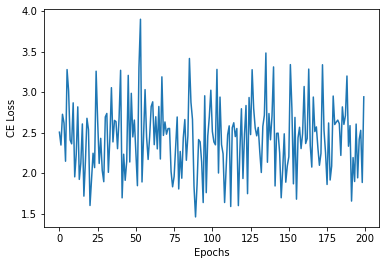

In [15]:
if num_epochs == len(train_losses):
    plt.plot(torch.Tensor(train_losses).detach().numpy())
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
else:
    raise 'Training is not finished.'

In [16]:
# save the trained model
torch.save(model.state_dict(), 'AutoEncoder_CIFAR-10.pt')

## Compare the original and encoded images

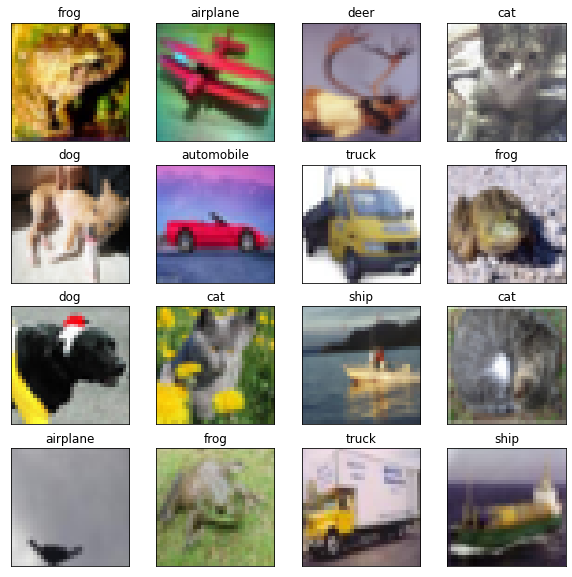

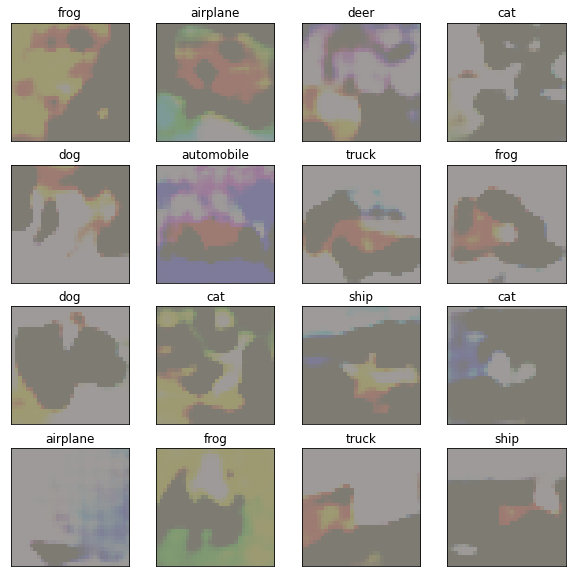

In [17]:
model2 = AutoEncoder()
model2.load_state_dict(torch.load('AutoEncoder_CIFAR-10.pt'))
model2.eval()

with torch.no_grad():
    count = 0

    input_list = []
    lab_list = []
    pred_list = []

    for image, label in test_data:
        image_ = image * stds.reshape(3,1,1) + means.reshape(3,1,1)
        input_list.append(image_)
        lab_list.append(class_idx_to_names[label])

        pred = model2(image.reshape(-1,3,32,32).to(device))[0,:,:,:] * \
               stds.reshape(3,1,1) + means.reshape(3,1,1)
        pred_list.append(pred)
        count += 1
        if count >= 16:
            break

    img_plotter(input_list, lab_list)
    img_plotter(pred_list, lab_list)